<a href="https://colab.research.google.com/github/snehaa-13/shock-propagation/blob/main/interbank_data_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

required libraries for data simulation

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta

global simulation parameters

In [3]:
core_banks = 20
periphery_banks = 47
total_banks = core_banks+periphery_banks
edge_prob_core = 0.8
edge_prob_periphery = 0.4
min_loan = 10
max_loan = 100
time_steps = 6
bank_id = [f'B{i}' for i in range(total_banks)]


bank attributes initialisation

In [4]:
data =[]
for t in range(time_steps) :
    for bank in bank_id :

        equity = np.random.uniform(40,200)
        assets = np.random.uniform(500,1500)
        liabilities = assets-equity
        reserves = np.random.uniform(20,100)

        data.append({
                    "bank_id": bank,
                    "time": t,
                    "equity": round(equity, 2),
                    "assets": round(assets, 2),
                    "liabilities": round(liabilities, 2),
                    "reserves": round(reserves, 2),
                    "shock_flag": 0,
                    "distress_level": 0.0,
                    "default_status": 0,
                    "state": "U"
                })

bank_df = pd.DataFrame(data)
bank_df.head()

,bank_id,time,equity,assets,liabilities,reserves,shock_flag,distress_level,default_status,state
0,B0,0,135.66,622.77,487.12,20.61,0,0.0,0,U
1,B1,0,84.88,1129.59,1044.71,58.67,0,0.0,0,U
2,B2,0,196.78,1118.08,921.29,70.47,0,0.0,0,U
3,B3,0,158.14,1187.55,1029.41,27.41,0,0.0,0,U
4,B4,0,45.77,1335.69,1289.92,74.14,0,0.0,0,U


In [5]:

bank_df.to_csv("bank_attributes_temporal.csv", index=False)
from google.colab import files
files.download("bank_attributes_temporal.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
import random
loan_density = 0.15
min_exposure = 5
max_exposure = 50
interest_rate_range = (0.01, 0.05)
maturity_terms = [7, 14, 30, 90, 180]

loan_data = []

for t in range(time_steps):
    for source in bank_id:
        for target in bank_id:
            if source != target and random.random() < loan_density:
                exposure = round(random.uniform(min_exposure, max_exposure), 2)
                interest_rate = round(random.uniform(*interest_rate_range), 4)
                maturity = random.choice(maturity_terms)
                loan_data.append({
                    "time": t,
                    "source": source,
                    "target": target,
                    "exposure": exposure,
                    "interest_rate": interest_rate,
                    "maturity": maturity
                })

loan_df = pd.DataFrame(loan_data)
loan_df.head()


,time,source,target,exposure,interest_rate,maturity
0,0,B0,B4,12.34,0.0111,180
1,0,B0,B7,22.91,0.0103,90
2,0,B0,B18,10.32,0.0398,7
3,0,B0,B20,10.48,0.0311,180
4,0,B0,B22,42.05,0.0300,180


In [7]:

bank_df.to_csv("bank_transactions.csv", index=False)
from google.colab import files
files.download("bank_transactions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

node-edge diagram

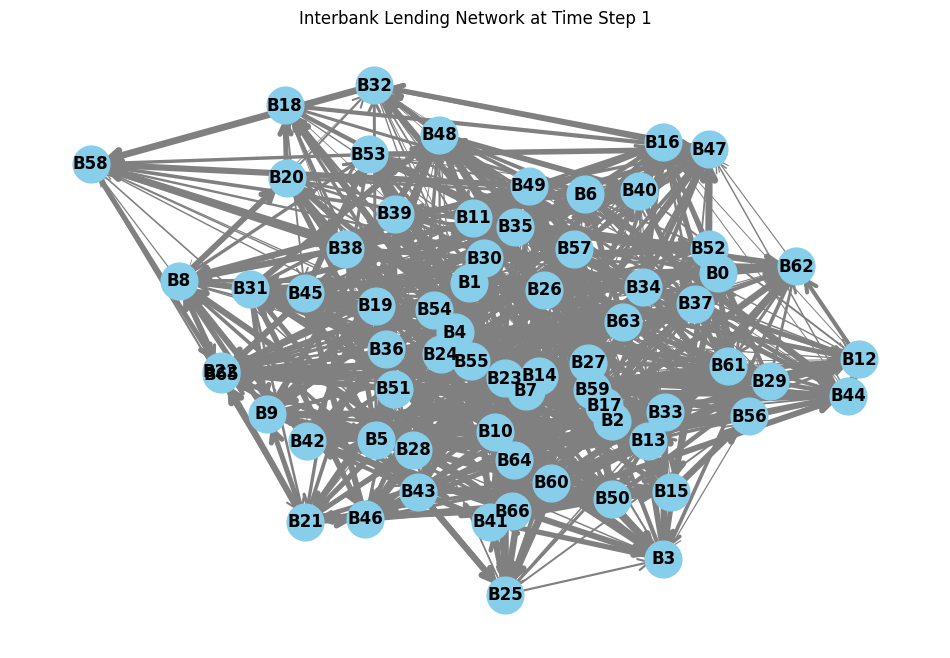

In [8]:
import networkx as nx
import matplotlib.pyplot as plt


time_step = 1
snapshot_df = loan_df[loan_df['time'] == time_step]


G = nx.DiGraph()


for idx, row in snapshot_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['exposure'])


pos = nx.spring_layout(G, seed=42)


plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
nx.draw_networkx_edges(
    G, pos, arrowstyle='->', arrowsize=20,
    width=[d['weight'] / 10 for u, v, d in G.edges(data=True)], edge_color='gray'
)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

plt.title(f"Interbank Lending Network at Time Step {time_step}")
plt.axis('off')
plt.show()


In [9]:
import numpy as np


time_steps = loan_df['time'].nunique()
bank_ids = bank_df['bank_id'].unique()


temporal_bank_data = []

for t in range(time_steps):
    for bank_id in bank_ids:
        temporal_bank_data.append({
            'time': t,
            'bank_id': bank_id,
            'equity': bank_df.loc[bank_df['bank_id'] == bank_id, 'equity'].values[0],
            'assets': bank_df.loc[bank_df['bank_id'] == bank_id, 'assets'].values[0],
            'liabilities': bank_df.loc[bank_df['bank_id'] == bank_id, 'liabilities'].values[0],
            'reserves': bank_df.loc[bank_df['bank_id'] == bank_id, 'reserves'].values[0],

            # Simulation control variables (initialized)
            'shock_flag': 0,                    # 0 by default; can set 1 later for any initial shocked bank
            'distress_level': 0.0,              # Continuous distress score
            'default_status': 0,                # 0: not defaulted
            'state': 'U'                        # U: Undistressed
        })

# Create the DataFrame
temporal_bank_df = pd.DataFrame(temporal_bank_data)


In [10]:
# Export temporal bank dataset as CSV
temporal_bank_df.to_csv("temporal_bank_dataset.csv", index=False)
from google.colab import files
files.download("temporal_bank_dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

baseline diagonostics

In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


time_step = 0
filtered_loans = loan_df[loan_df['time'] == time_step]


G = nx.from_pandas_edgelist(
    filtered_loans,
    source='source',
    target='target',
    edge_attr='exposure',
    create_using=nx.DiGraph()
)


degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
betweenness_centrality = nx.betweenness_centrality(G)
core_number = nx.core_number(G)
clustering_coefficient = nx.clustering(G.to_undirected())


centrality_df = pd.DataFrame({
    'bank_id': list(G.nodes()),
    'degree_centrality': [degree_centrality[node] for node in G.nodes()],
    'eigenvector_centrality': [eigenvector_centrality[node] for node in G.nodes()],
    'betweenness_centrality': [betweenness_centrality[node] for node in G.nodes()],
    'core_number': [core_number[node] for node in G.nodes()],
    'clustering_coefficient': [clustering_coefficient[node] for node in G.nodes()]
})


centrality_df.head()


,bank_id,degree_centrality,eigenvector_centrality,betweenness_centrality,core_number,clustering_coefficient
0,B0,0.257576,0.069852,0.010787,15,0.209524
1,B4,0.363636,0.140439,0.025191,15,0.284585
2,B7,0.303030,0.103523,0.012705,15,0.286550
3,B18,0.272727,0.124728,0.012591,15,0.267974
4,B20,0.318182,0.123689,0.016393,15,0.289474


In [12]:
centrality_df.to_csv('centrality_metrics_t0.csv', index=False)


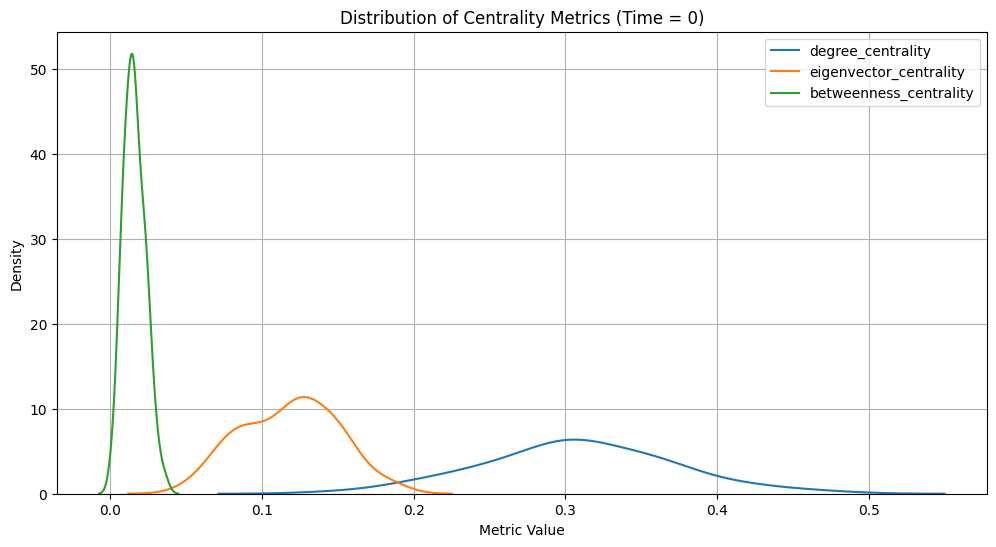

In [13]:
import seaborn as sns

plt.figure(figsize=(12, 6))
for metric in ['degree_centrality', 'eigenvector_centrality', 'betweenness_centrality']:
    sns.kdeplot(centrality_df[metric], label=metric)

plt.title("Distribution of Centrality Metrics (Time = 0)")
plt.xlabel("Metric Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
import pandas as pd
import networkx as nx


all_centrality_data = []


time_steps = loan_df['time'].unique()

for t in time_steps:

    filtered_loans = loan_df[loan_df['time'] == t]


    G = nx.from_pandas_edgelist(
        filtered_loans,
        source='source',
        target='target',
        edge_attr='exposure',
        create_using=nx.DiGraph()
    )


    if G.number_of_nodes() < 2:
        continue


    degree_centrality = nx.degree_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    core_number = nx.core_number(G)
    clustering_coefficient = nx.clustering(G.to_undirected())


    for node in G.nodes():
        all_centrality_data.append({
            'time': t,
            'bank_id': node,
            'degree_centrality': degree_centrality.get(node, 0),
            'eigenvector_centrality': eigenvector_centrality.get(node, 0),
            'betweenness_centrality': betweenness_centrality.get(node, 0),
            'core_number': core_number.get(node, 0),
            'clustering_coefficient': clustering_coefficient.get(node, 0)
        })


centrality_time_df = pd.DataFrame(all_centrality_data)

centrality_time_df.head()


,time,bank_id,degree_centrality,eigenvector_centrality,betweenness_centrality,core_number,clustering_coefficient
0,0,B0,0.257576,0.069852,0.010787,15,0.209524
1,0,B4,0.363636,0.140439,0.025191,15,0.284585
2,0,B7,0.303030,0.103523,0.012705,15,0.286550
3,0,B18,0.272727,0.124728,0.012591,15,0.267974
4,0,B20,0.318182,0.123689,0.016393,15,0.289474


In [15]:
centrality_time_df.to_csv("centrality_metrics_over_time.csv", index=False)


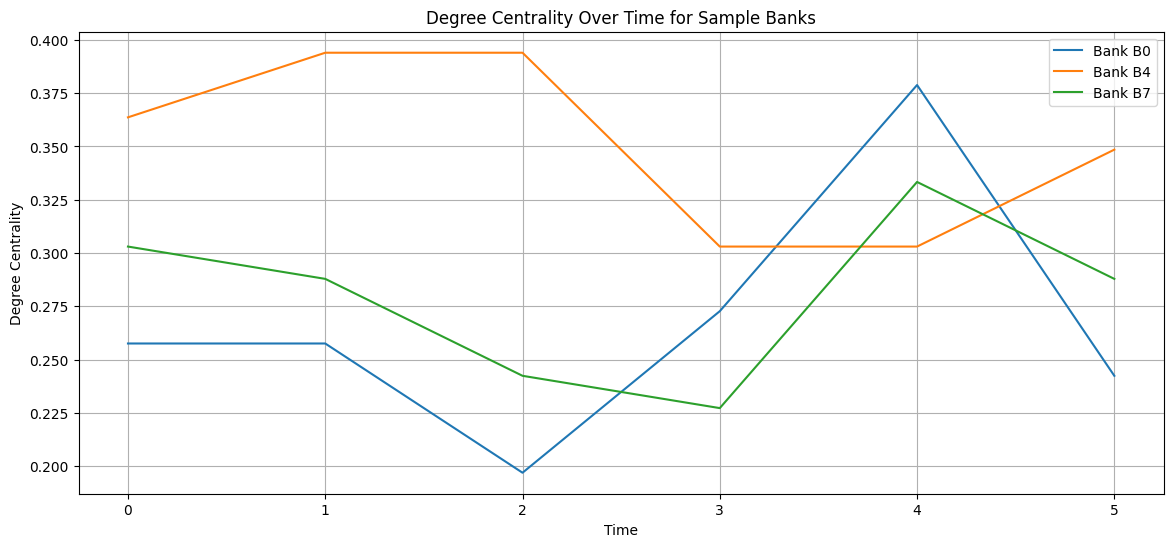

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


banks_to_plot = centrality_time_df['bank_id'].unique()[:3]

plt.figure(figsize=(14, 6))
for bank in banks_to_plot:
    bank_data = centrality_time_df[centrality_time_df['bank_id'] == bank]
    plt.plot(bank_data['time'], bank_data['degree_centrality'], label=f"Bank {bank}")

plt.xlabel("Time")
plt.ylabel("Degree Centrality")
plt.title("Degree Centrality Over Time for Sample Banks")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
!pip install pygraphviz


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pygraphviz
Failed to build pygraphviz
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pygraphviz)


In [18]:
import os
import matplotlib.pyplot as plt
import networkx as nx


os.makedirs("network_snapshots", exist_ok=True)


for t in sorted(loan_df['time'].unique()):
    # Filter for current time
    snapshot = loan_df[loan_df['time'] == t]


    G = nx.from_pandas_edgelist(
        snapshot,
        source='source',
        target='target',
        edge_attr='exposure',
        create_using=nx.DiGraph()
    )


    node_sizes = [300 + 1000 * G.degree(n) for n in G.nodes()]


    edge_weights = [0.5 + 3 * d['exposure'] / snapshot['exposure'].max() for _, _, d in G.edges(data=True)]


    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(f"Interbank Network at Time Step {t}")
    plt.axis('off')


    plt.savefig(f"network_snapshots/network_t{t}.png", bbox_inches='tight')
    plt.close()

print("✅ All network plots saved in 'network_snapshots' folder.")


✅ All network plots saved in 'network_snapshots' folder.


In [19]:
!zip -r network_snapshots.zip network_snapshots


  adding: network_snapshots/ (stored 0%)
  adding: network_snapshots/network_t2.png (deflated 8%)
  adding: network_snapshots/network_t0.png (deflated 8%)
  adding: network_snapshots/network_t1.png (deflated 9%)
  adding: network_snapshots/network_t4.png (deflated 8%)
  adding: network_snapshots/network_t5.png (deflated 7%)
  adding: network_snapshots/network_t3.png (deflated 9%)


In [20]:
!pip install imageio


In [21]:
import imageio
import os


img_folder = "network_snapshots"
output_gif_path = "interbank_network_evolution.gif"


image_files = sorted([os.path.join(img_folder, img) for img in os.listdir(img_folder) if img.endswith(".png")])


with imageio.get_writer(output_gif_path, mode='I', duration=1) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"✅ GIF saved as {output_gif_path}")


<ipython-input-21-0dfc57d368de>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


✅ GIF saved as interbank_network_evolution.gif


In [22]:
from IPython.display import Image
Image(filename="interbank_network_evolution.gif")
from google.colab import files
files.download("interbank_network_evolution.gif")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
import pandas as pd
import numpy as np




required_loan_cols = ['time', 'source', 'target', 'exposure']
required_bank_cols = ['time', 'bank_id', 'equity', 'shock_flag']



print("🔍 Checking for missing values...")
print("Loan DF:\n", loan_df[required_loan_cols].isnull().sum())
print("Bank DF:\n", bank_df[required_bank_cols].isnull().sum())


loan_df.fillna({'exposure': 0}, inplace=True)
bank_df.fillna({'equity': 0, 'shock_flag': 0}, inplace=True)


print("\n🔍 Checking data types...")
print("Loan DF types:\n", loan_df[required_loan_cols].dtypes)
print("Bank DF types:\n", bank_df[required_bank_cols].dtypes)


loan_df['exposure'] = loan_df['exposure'].astype(float)
bank_df['equity'] = bank_df['equity'].astype(float)
bank_df['shock_flag'] = bank_df['shock_flag'].astype(int)


print("\n🔍 Checking for duplicate loans...")
duplicates = loan_df.duplicated(subset=['time', 'source', 'target'])
print(f"Found {duplicates.sum()} duplicate rows.")
loan_df = loan_df[~duplicates]


print("\n🔍 Ensuring each bank has an entry at each timestep...")
expected_entries = bank_df['bank_id'].nunique() * bank_df['time'].nunique()
actual_entries = len(bank_df)
missing_entries = expected_entries - actual_entries
print(f"Missing entries: {missing_entries}")


all_times = bank_df['time'].unique()
all_banks = bank_df['bank_id'].unique()
full_index = pd.MultiIndex.from_product([all_banks, all_times], names=['bank_id', 'time'])
bank_df = bank_df.set_index(['bank_id', 'time']).reindex(full_index, fill_value=0).reset_index()


print("\n🔍 Checking for invalid edges (self-loops or negative weights)...")
self_loops = loan_df[loan_df['source'] == loan_df['target']]
neg_edges = loan_df[loan_df['exposure'] < 0]
print(f"Self-loops: {len(self_loops)} | Negative exposures: {len(neg_edges)}")

loan_df = loan_df[loan_df['source'] != loan_df['target']]
loan_df = loan_df[loan_df['exposure'] >= 0]


print("\n🔍 Ensuring all source/target banks exist in node table...")
valid_ids = set(bank_df['bank_id'].unique())
invalid_sources = ~loan_df['source'].isin(valid_ids)
invalid_targets = ~loan_df['target'].isin(valid_ids)
print(f"Invalid sources: {loan_df[invalid_sources].shape[0]} | Invalid targets: {loan_df[invalid_targets].shape[0]}")

loan_df = loan_df[~invalid_sources & ~invalid_targets]


print("\n✅ Sanity Check Complete.")
print(f"Cleaned loan_df: {loan_df.shape[0]} edges")
print(f"Cleaned bank_df: {bank_df.shape[0]} entries")


🔍 Checking for missing values...
Loan DF:
 time        0
source      0
target      0
exposure    0
dtype: int64
Bank DF:
 time          0
bank_id       0
equity        0
shock_flag    0
dtype: int64

🔍 Checking data types...
Loan DF types:
 time          int64
source       object
target       object
exposure    float64
dtype: object
Bank DF types:
 time            int64
bank_id        object
equity        float64
shock_flag      int64
dtype: object

🔍 Checking for duplicate loans...
Found 0 duplicate rows.

🔍 Ensuring each bank has an entry at each timestep...
Missing entries: 0

🔍 Checking for invalid edges (self-loops or negative weights)...
Self-loops: 0 | Negative exposures: 0

🔍 Ensuring all source/target banks exist in node table...
Invalid sources: 0 | Invalid targets: 0

✅ Sanity Check Complete.
Cleaned loan_df: 4009 edges
Cleaned bank_df: 402 entries


In [24]:

loan_df.to_csv("cleaned_loan_data.csv", index=False)
bank_df.to_csv("cleaned_bank_data.csv", index=False)

print("✅ CSV files saved in Colab filesystem.")
from google.colab import files

files.download("cleaned_loan_data.csv")
files.download("cleaned_bank_data.csv")


✅ CSV files saved in Colab filesystem.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>